<a href="https://colab.research.google.com/github/mknomics/soda/blob/main/Elasticity_Tool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SODA DATA
This dataset contains product level montly data for multiple stores and soda brands within Greece.  

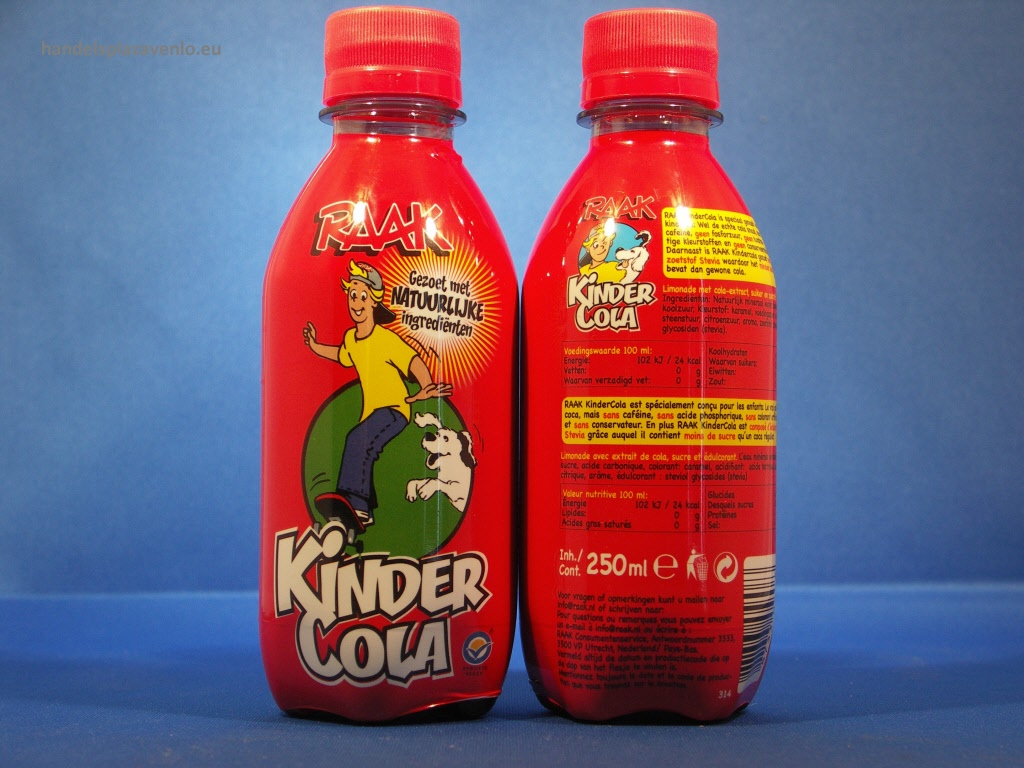


**IMPORTANT DISCLAIMER**  I use this dataset to do a naive estimation of various demand equations BUT doing so is hazardously wrong in practice.  Why? The Data points in this set are the result of an interaction of BOTH supply AND demand.  Our interpretation of Demand is "willingness-to-pay".  A true demand schedule is more properly represented in the [Google Sheet](https://docs.google.com/spreadsheets/d/1w5R60JGle5JAWz_wFuQ7dutR948jm60gSvcUTqK2UUI/edit?usp=sharing) that we completed in class.  

A more robust estimation would use causal analysis and other experimental methods not covered here.  Explicitly Stated:  elasticity is the causal impact on quantity for a percentage change in price. 

## Click "Play" button below

In [55]:
#@title
import pandas as pd  #pandas is good for data manipulation.  I rename it here as "pd" to make it easier to call in the script below.  I could rename it anything I want but "pd" is standard
import matplotlib.pyplot as plt #matplotlib is a good package for graphing.  Again, I rename it plt to make coding more simple
import numpy as np #numpy is a good package for doing calculations
from sklearn.linear_model import LinearRegression  #sklearn is a package that is good at estimation.  Tons of models are available and here I import LinearRegression because that's all I need
from IPython.core.display import HTML
from IPython.display import display, Markdown, clear_output
import ipywidgets as widgets
import numpy as np
from sklearn.linear_model import LinearRegression

brands=['adult-cola', 'gazoza', 'kinder-cola', 'lemon-boost', 'orange-power']
container = ['plastic', 'can', 'glass']

########################## Work the data #####################################

#Import a csv file from a target url:  What is a csv file?  Go to the url below to see the raw data.  columns are separated by a "," and the last column lacks a ","
data_url='https://raw.githubusercontent.com/mknomics/soda/main/soda.csv' # I define a string variable using apostrophe ' but I could ahve also used quotes " ".  I just cannot mix apostophe and quotes in the same line
df = pd.read_csv(data_url) # This line creates a pandas DataFrame that I defined as "df".  I could have called it anything I want

# Set my date objects.  This must be done so that 'date' is recognized as a date and not just a random string variable
df['date']=pd.to_datetime(df['date']) #make date a datetime object
df['year']=pd.DatetimeIndex(df['date']).year # I define a variable 'year' using the DatetimeIndex method
df['month']=pd.DatetimeIndex(df['date']).month # similarly I repeat and define 'month'

#Step 1: use groupby method and define a new dataframe for each of the metrics that we are interested in
df_mean_Q = df.groupby(['brand','container','city','date'])['quantity'].mean().reset_index()# I reset the index for each new data set.  Don't worry if the indexing is confusing since it isn't the main point here
df_mean_P = df.groupby(['brand','container','city','date'])['price'].mean().reset_index()
# Step 2: the data frames from Step #1 can be merged by their unique rows.  Rows are unique by city x brand x container x date
df_city = pd.merge(df_mean_Q, df_mean_P) # merges df_total_Q dataframe with df_mean_P dataframe based on their unique rows

# Now let's rename the price and quantity column so we don't get confused later about what we are looking at
df_city.rename(columns={'quantity': 'mean_q', 'price': 'mean_p'},inplace=True) # I 

# we lost our columns df['year'] and df['month'] so lets add these back
df_city['year']=pd.DatetimeIndex(df_city['date']).year # I define a variable 'year' using the DatetimeIndex method
df_city['month']=pd.DatetimeIndex(df_city['date']).month # similarly I repeat and define 'month'about what we are looking at
df_city.rename(columns={'quantity': 'mean_q', 'price': 'mean_p'},inplace=True) 

df_city = df_city.pivot(index='date', columns=['city','brand','container'], values=['mean_q','mean_p'])

###################### Defnine Functions ########################################

def Athens(Q_brand=True, Q_container=True, P_brand=True, P_container=True):
 # define independent variable X
  X = df_city['mean_q']['Athens'][Q_brand][Q_container].values.reshape(-1,1) #convert to numpy array using "values"
  # define dependent variable Y
  Y = df_city['mean_p']['Athens'][P_brand][P_container].values.reshape(-1,1)
  linear_regression = LinearRegression() # Create a linear_regression object
  linear_regression.fit(X , Y)  # Fit the model
  Y_pred = linear_regression.predict(X)  # Fits the Data Points "X" with the parameters from the Fit step to form a prediction
  plt.scatter(X, Y)
  plt.plot(X, Y_pred, color='red')
  plt.title('Price and Quantity')
  plt.xlabel('Quantity '+ " " + Q_brand+ " " + Q_container)
  plt.ylabel('Price' +" " + P_brand + " " + P_container)

  return plt.show()


def own_price(Q_brand=True, Q_container=True, PricePoint=True):
  Athens(Q_brand=Q_brand,Q_container=Q_container,P_brand=Q_brand,P_container=Q_container)
  Qx = df_city['mean_q']['Athens'][Q_brand][Q_container].values.reshape(-1,1) #convert to numpy array using "values"
  # define dependent variable Y
  Px = df_city['mean_p']['Athens'][Q_brand][Q_container].values.reshape(-1,1)
  reg = LinearRegression().fit(Px, Qx)
  reg.score(Px, Qx)
  P=PricePoint
  Q_hat=reg.predict(np.array(P).reshape(-1, 1))
  elasticity=reg.coef_ * (P/Q_hat)  
  return print('elasticity = ' + str(elasticity))


def cross_price(Q_brand=True, Q_container=True, P_brand=True, P_container=True, PricePoint=True):
  Athens(Q_brand=Q_brand,Q_container=Q_container,P_brand=P_brand,P_container=P_container)
  Qx = df_city['mean_q']['Athens'][Q_brand][Q_container].values.reshape(-1,1) #convert to numpy array using "values"
  # define dependent variable Y
  Px1 = df_city['mean_p']['Athens'][Q_brand][Q_container].values.reshape(-1,1)
  Px2 = df_city['mean_p']['Athens'][P_brand][P_container].values.reshape(-1,1)
  Px = np.concatenate((Px1, Px2), axis=1)
  mPx1 = np.mean(Px1)
  reg = LinearRegression().fit(Px, Qx)
  reg.score(Px, Qx)
  P=np.array([[mPx1, PricePoint]])
  Q_hat=reg.predict(P)
  return print('the cross-price-elasticity for ' + P_brand + ' is =' + str((reg.coef_ *(PricePoint/Q_hat))[0][1]))


def cross_price_plot(brand=True, container=True):
  for i in brands:
    if i !=brand:
      PricePoint=np.mean(df_city['mean_p']['Athens'][i][container])
      cross_price(Q_brand=brand, Q_container=container, P_brand=i, P_container=container, PricePoint=PricePoint)



################### Define Widgets #############################################

price_slider = widgets.FloatSlider(min=0.01, max=10.0, step=0.05, description='Price')
price_slider2 = widgets.FloatSlider(min=0.01, max=10.0, step=0.05, description='Price')

brand_menu = widgets.Dropdown(
       options=brands,
       value='adult-cola',
       description='Brand 1:')

container_menu = widgets.Dropdown(
       options=container,
       value='plastic',
       description='Container 1:')

brand_menu2 = widgets.Dropdown(
       options=brands,
       value='gazoza',
       description='Brand 2:')

container_menu2 = widgets.Dropdown(
       options=container,
       value='plastic',
       description='Container 2:')

# Define Button to execute 
elasticity_button = widgets.Button(description='Click-4-Elasticity')
elast_out = widgets.Output()
def own_price_button(_):
      with elast_out:  # "linking function with output"
        clear_output()
        print(own_price(Q_brand=brand_menu.value, Q_container=container_menu.value, PricePoint=price_slider.value))
elasticity_button.on_click(own_price_button)  # linking button and function together using a button's method

cross_button = widgets.Button(description='Click-4-Cross-Price')
cp_elast_out = widgets.Output()
def cp_button(_):
      with cp_elast_out:  # "linking function with output"
        clear_output()
        print(cross_price(Q_brand=brand_menu.value, 
                    Q_container=container_menu.value, 
                    PricePoint=price_slider2.value, 
                    P_brand=brand_menu2.value, 
                    P_container=container_menu2.value))
cross_button.on_click(cp_button)  # linking button and function together using a button's method

market_button = widgets.Button(description='Click-4-Market')
market_out = widgets.Output()
def m_button(_):
      with market_out:  # "linking function with output"
        clear_output()
        print(cross_price_plot(brand=brand_menu.value, container=container_menu.value))
market_button.on_click(m_button)  # linking button and function together using a button's method

# Present Widgets
own_price_box=widgets.VBox([brand_menu, container_menu,price_slider,elasticity_button,elast_out])  
c_price_box=widgets.VBox([brand_menu2, container_menu2,price_slider2,cross_button,cp_elast_out])  
market_box=widgets.VBox([brand_menu, container_menu,market_button,market_out]) 
print('**********************************************************************') 
print('Print out of the first 5 rows from the raw data')
print('**********************************************************************')
print(df.head())
print('**********************************************************************')
print('Use the tools below to answer the questions')
print('**********************************************************************')

widgets.HBox([own_price_box,c_price_box,market_box])



**********************************************************************
Print out of the first 5 rows from the raw data
**********************************************************************
     id       date    city       lat      long     pop    shop       brand  \
0  1222 2013-02-28  Athens  37.96245  23.68708  671022  shop_3  adult-cola   
1  1256 2013-02-28  Athens  37.97945  23.71622  671022  shop_1  adult-cola   
2  2325 2014-02-28  Athens  37.97945  23.71622  668203  shop_1  adult-cola   
3  2333 2014-02-28  Athens  37.96245  23.68708  668203  shop_3  adult-cola   
4  3334 2015-02-28  Athens  37.97945  23.71622  667237  shop_1  adult-cola   

  container capacity  price  quantity  year  month  
0   plastic    1.5lt   2.46     10709  2013      2  
1   plastic    1.5lt   1.91     12703  2013      2  
2   plastic    1.5lt   3.99      3642  2014      2  
3   plastic    1.5lt   2.82      9282  2014      2  
4   plastic    1.5lt   1.29     15782  2015      2  
***********************

## Regression Methods of Estimating Elasticity
This section is optional but may help you to understand what is going on under the hood

#### What is the best fit line that can possibly be made given the data?  

# $Y = \beta_x X + \beta_0 + \epsilon$
Think $Y=mX+b$ where $m=\beta_x$ and $b=\beta_0$ and $\epsilon$ is an error term

#### If the data is given then a line is defined by the coefficients $\beta_x , \beta_0$

#### Find the "best" values of $\beta_x , \beta_0$.  where "best" minimizes statistical error $\epsilon$

How can we sum up all errors?  Some are positive and some are negative?  Solution: define the error as the squared error loss $$\sum\epsilon^2$$ 

# Own Price-Elasticity of Demand
# $Q_x = \beta_0 + \beta_x P_x + \epsilon$
where: 

*   $Q_x$ is the quantity of good X
*   $P_x$ is the price of good X
*   $P_y$ is the price of good Y

The Price-Elasticity of Demand is given by:

$\frac{\Delta Q_x}{\Delta P_x} \frac{P_x}{Q_x} = \beta_x \frac{P_x}{Q_x}$

# Cross-Price-Elasticity

# $Q_x = \beta_0 + \beta_x P_x + \beta_y P_y + \epsilon$
where: 


*   $Q_x$ is the quantity of good X
*   $P_x$ is the price of good X
*   $P_y$ is the price of good Y



####**QUESTION 1:**  
Is there a positive or negative relationship?

### Substitutes or Not-Related? 
If goods A and B are substitutes then we would expect that higher prices of good A would be positively related to higher quantities of good B

If goods A and B are not related then we would expect a scatter plot of the Quantity of good A and the Price of good B to have neither a positive nor negative relationship


#### Application:  Revenue Canibalism 
Consider that if two goods, within a firm's product basket, are substitutes, then a promoting one product with a price decrease can canibalize the sale of another product in your brand, thus reducing or even having a negative impact on your overall brand sales.  On the other hand if goods are not related then dropping the price on one product line might have minimal impact on the sales of other brands.  


#####**QUESTION 2:**  
You are the brand ambassador for adult-cola.  Do you have any concerns for canibalism if you drop your price on cans?  In other words, do you see any potential negative impact on your sales of glass or plastic products?


##### **QUESTION 3:**

You are the store manager:  Do you have any concerns of canibalism of gazoza cans if you drop the price of adult-cola cans?

##### **QUESTION 4:**

Do you find any evidence of substitution effects between adult-cola cans and kinder-cola cans?

How about orange-power cans and lemon-boost cans?
